In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from collections import Counter
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/glove-global-vectors-for-word-representation"))
print(os.listdir("../input/jigsaw-unintended-bias-in-toxicity-classification"))
print(os.listdir("../input/fasttext-crawl-300d-2m"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['glove-global-vectors-for-word-representation', 'jigsaw-unintended-bias-in-toxicity-classification', 'fasttext-crawl-300d-2m']
['glove.6B.200d.txt', 'glove.6B.50d.txt', 'glove.6B.100d.txt']
['sample_submission.csv', 'all_data.csv', 'test_public_expanded.csv', 'test_private_expanded.csv', 'toxicity_individual_annotations.csv', 'train.csv', 'identity_individual_annotations.csv', 'test.csv']
['crawl-300d-2M.vec']


In [2]:
# Config
SEED = 11
TARGET = 'target'
TEXT = 'comment_text'
PREDICTION = 'prediction'
IDENTITY = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim',
            'black', 'white', 'psychiatric_or_mental_illness']
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 250
TEST_SIZE = 0.01
EMBEDDINGS_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
EMBEDDINGS_DIMENSION = 300
DROPOUT_RATE = 0.3
LEARNING_RATE = 1e-5
NUM_EPOCHS = 10
BATCH_SIZE = 128


In [3]:
CONTRACTIONS = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not", 
                "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
                "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
                "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have",
                "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "it's": "it is" }


In [4]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')

# Make sure all comment_text values are strings
train[TEXT] = train[TEXT].astype(str) 

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in [TARGET] + IDENTITY:
        convert_to_bool(bool_df, col)
    return bool_df

train = convert_dataframe_to_bool(train)


In [5]:
train.shape

(1804874, 45)

In [6]:
# All comments must be truncated or padded to be the same length.
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)


def _embeddings_index(path):
    """Load embeddings"""
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


def _unknown_words(vocab, embeddings_index):
    known_words_count_unique = 0
    known_words_count = 0
    unknown_words_count = 0
    unknown_words = Counter()
    for word in vocab.keys():
        em = embeddings_index.get(word, None)
        c = vocab.get(word)
        if em is None:
            unknown_words_count += c
            unknown_words[word] += c
        else:
            known_words_count_unique += 1
            known_words_count += c
    print('Found embeddings for {:.3%} of vocab'.format(known_words_count_unique / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(known_words_count / (known_words_count + unknown_words_count)))
    return unknown_words


def add_lowercase_to_embeddings(embeddings_index, vocab):
    c = 0
    for word in vocab:
        l = word.lower()
        if word in embeddings_index and l not in embeddings_index:  
            embeddings_index[l] = embeddings_index[word]
            c += 1
    print('add_lowercase_to_embeddings: added {} words'.format(c))


def clean_contractions(str, mapping=CONTRACTIONS):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        str = str.replace(s, "'")
    res = ' '.join([mapping[t] if t in mapping else t for t in str.split(' ')])
    return res
    

train[TEXT] = train[TEXT].apply(lambda x: clean_contractions(x))
# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train[TEXT])
vocab = Counter(tokenizer.word_counts)
print('most common vocab: {}'.format(vocab.most_common(100)))



    

most common vocab: [('the', 4761525), ('to', 2667888), ('and', 2296943), ('of', 2062230), ('a', 1976994), ('is', 1782943), ('in', 1407762), ('that', 1348197), ('not', 1205767), ('i', 1053305), ('it', 1020002), ('you', 1016973), ('for', 963749), ('are', 843872), ('have', 678430), ('be', 642296), ('on', 623871), ('they', 608863), ('this', 591775), ('with', 588216), ('as', 539171), ('do', 498039), ('was', 466020), ('will', 433464), ('or', 429218), ('but', 422684), ('we', 412807), ('he', 408156), ('if', 382228), ('all', 381338), ('what', 372634), ('would', 355349), ('their', 353213), ('by', 346825), ('so', 332536), ('from', 332141), ('who', 331377), ('your', 328754), ('at', 327454), ('no', 319082), ('has', 308681), ('about', 301129), ('people', 301042), ('there', 283215), ('an', 280400), ('more', 275184), ('his', 270791), ('one', 262834), ('just', 262208), ('like', 257828), ('can', 248930), ('out', 232064), ('when', 221510), ('up', 218717), ('trump', 216474), ('our', 213560), ('how', 20518

In [7]:
embeddings_index = _embeddings_index(EMBEDDINGS_PATH)
# Glove does not have contractions such as "it's", "that's"
#print("it is={}".format("it is" in embeddings_index))
#print("that is={}".format("that is" in embeddings_index))
add_lowercase_to_embeddings(embeddings_index, vocab)
unknown_words = _unknown_words(vocab, embeddings_index)
print('{} unknown words'.format(len(unknown_words)))
print('most common unknown words: {}'.format(unknown_words.most_common(1000)))

add_lowercase_to_embeddings: added 0 words
Found embeddings for 38.529% of vocab
Found embeddings for  98.745% of all text
240338 unknown words
most common unknown words: [("trump's", 27931), ("let's", 15225), ("i'm", 10655), ("canada's", 8872), ("what's", 8738), ("obama's", 6513), ("here's", 6422), ("people's", 6132), ("one's", 5754), ("today's", 5506), ('khadr', 5168), ("trudeau's", 4767), ("alaska's", 4208), ("god's", 3956), ("women's", 3876), ("world's", 3346), ('murkowski', 3194), ("america's", 3164), ("clinton's", 3160), ("state's", 3149), ("gov't", 2968), ("you've", 2884), ("we've", 2882), ('“the', 2636), ("government's", 2513), ("hillary's", 2508), ("else's", 2498), ("i've", 2492), ("we'll", 2490), ("country's", 2479), ("man's", 2244), ("wouldn't", 2177), ("o'leary", 2177), ("nation's", 2154), ("person's", 2100), ("aren't", 2089), ("someone's", 2089), ("church's", 2067), ("i'll", 2029), ("wasn't", 1944), ("harper's", 1933), ('“i', 1891), ("president's", 1873), ('siemian', 1868)

In [8]:
train_df, validate_df = train_test_split(train, test_size=TEST_SIZE, random_state=SEED)
train_df.shape, validate_df.shape

((1786825, 45), (18049, 45))

In [9]:
def _embedding_matrix(embeddings_index, tokenizer, dimension_size):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, dimension_size))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def train_model(train_df, validate_df, tokenizer, embeddings_index):
    """Define and train a Convolutional Neural Net for classifying toxic comments"""
    # Prepare data
    train_text = pad_text(train_df[TEXT], tokenizer)
    train_labels = to_categorical(train_df[TARGET])
    validate_text = pad_text(validate_df[TEXT], tokenizer)
    validate_labels = to_categorical(validate_df[TARGET])

    embedding_matrix = _embedding_matrix(embeddings_index, tokenizer, dimension_size=EMBEDDINGS_DIMENSION)
    

    # Create model layers.
    def get_convolutional_neural_net_layers():
        """Returns (input_layer, output_layer)"""
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(sequence_input)
        x = Conv1D(128, 2, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 4, activation='relu', padding='same')(x)
        x = MaxPooling1D(40, padding='same')(x)
        x = Flatten()(x)
        x = Dropout(rate=DROPOUT_RATE, seed=SEED)(x)
        x = Dense(128, activation='relu')(x)
        preds = Dense(2, activation='softmax')(x)
        return sequence_input, preds

    # Compile model.
    print('compiling model...')
    input_layer, output_layer = get_convolutional_neural_net_layers()
    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=LEARNING_RATE),
                  metrics=['acc'])

    # Train model.
    print('training model...')
    history = model.fit(train_text,
                  train_labels,
                  batch_size=BATCH_SIZE,
                  epochs=NUM_EPOCHS,
                  validation_data=(validate_text, validate_labels),
                  verbose=2)

    return model, history

model, history = train_model(train_df, validate_df, tokenizer, embeddings_index)
model.summary()

compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
training model...
Instructions for updating:
Use tf.cast instead.
Train on 1786825 samples, validate on 18049 samples
Epoch 1/10
 - 123s - loss: 0.2248 - acc: 0.9260 - val_loss: 0.1705 - val_acc: 0.9396
Epoch 2/10
 - 120s - loss: 0.1654 - acc: 0.9404 - val_loss: 0.1544 - val_acc: 0.9438
Epoch 3/10
 - 119s - loss: 0.1555 - acc: 0.9437 - val_loss: 0.1498 - val_acc: 0.9459
Epoch 4/10
 - 120s - loss: 0.1509 - acc: 0.9451 - val_loss: 0.1459 - val_acc: 0.9474
Epoch 5/10
 - 120s - loss: 0.1478 - acc: 0.9460 - val_loss: 0.1433 - val_acc: 0.9475
Epoch 6/10
 - 120s - loss: 0.1440 - acc: 0.9473 - val_loss: 0.1417 - val_acc: 0.9487
Epoch 8/10
 - 120s - loss: 0.1426 - acc: 0.9477 - val_loss: 0.1407 - val_acc: 0.9490
Epoch 9/10
 - 119s - loss: 0.1416 - acc: 0.9479 - val_loss: 0.1408 - val_acc: 0.9

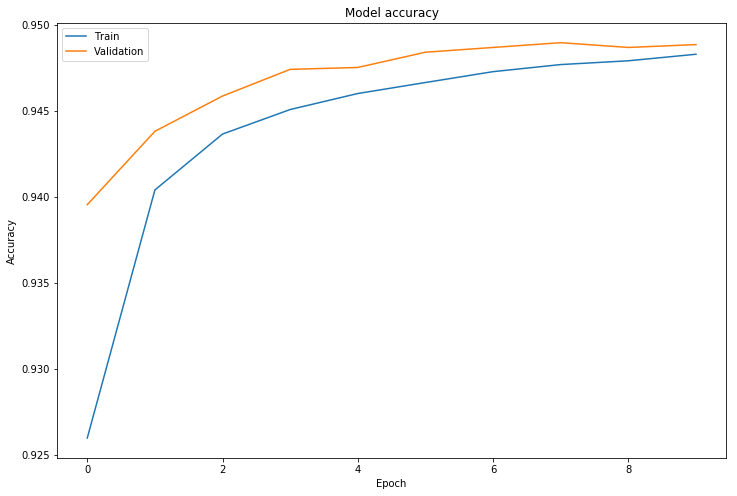

In [10]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

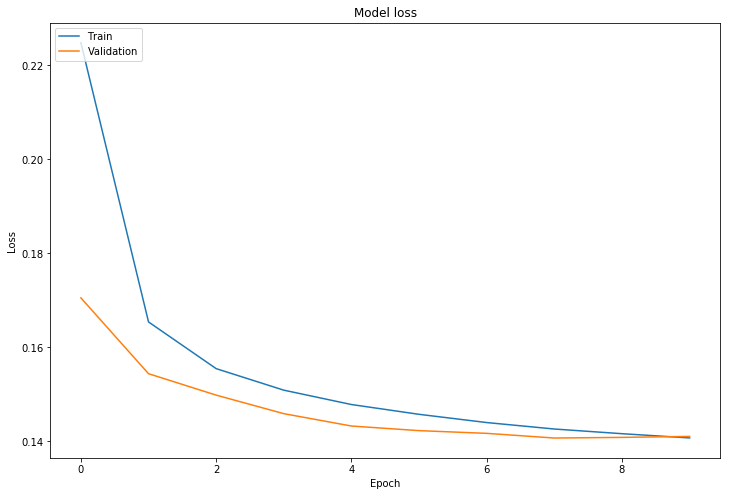

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
validate_df[PREDICTION] = model.predict(pad_text(validate_df[TEXT], tokenizer))[:, 1]
validate_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,prediction
555711,923100,False,"Lydia,\nThose are strange facts. \nThe Nazi pa...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,False,0.0,0.0,False,0.0,True,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,2017-01-30 20:44:47.536078+00,53,914894.0,164473,approved,0,0,0,0,0,0.0,4,4,0.052697
1610468,6093399,False,We'll miss you.,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2017-10-06 04:03:55.139499+00,54,6092890.0,385407,rejected,0,0,0,0,0,0.0,0,4,0.017151
228580,522484,False,Brava!👏👏,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2016-10-11 23:03:39.762684+00,22,522303.0,148209,approved,0,0,0,3,0,0.0,0,10,0.085549
515703,874887,False,The ancient Church of both East and West does ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,True,False,0.0,0.0,False,0.0,False,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,2017-01-21 18:15:59.916434+00,22,873156.0,162998,approved,0,0,0,0,0,0.0,4,4,0.013517
516211,875445,False,I heard that President Trump was going to be m...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2017-01-21 19:37:07.343866+00,54,NaN,163303,approved,0,0,0,0,0,0.0,0,6,0.004241


In [33]:
class JigsawEvaluator:

    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        """Restrict the data set to only the examples that mention the specific identity subgroup.
        A low value in this metric means the model does a poor job of distinguishing
        between toxic and non-toxic comments that mention the identity."""
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        """BPSN (Background Positive, Subgroup Negative) AUC:
        Restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not.
        A low value in this metric means that the model confuses non-toxic examples
        that mention the identity with toxic examples that do not,
        likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity."""
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        """BNSP (Background Negative, Subgroup Positive) AUC:
        Restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not.
        A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not,
        likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity."""
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records
    
    def _compute_bias_metrics(self, y_pred):
        records = []
        for i in range(self.n_subgroups):
            record = {
                'subgroup': IDENTITY[i],
            }
            record['subgroup_auc'] = self._compute_subgroup_auc(i, y_pred)
            record['bpsn_auc'] = self._compute_bpsn_auc(i, y_pred)
            record['bnsp_auc'] = self._compute_bnsp_auc(i, y_pred)
            records.append(record)
        return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self._compute_bias_metrics_for_model(y_pred)
        bias_metrics_df = self._compute_bias_metrics(y_pred)
        print(bias_metrics_df)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score

In [34]:
y_true = validate_df[TARGET].values
y_identity = validate_df[IDENTITY].values

# predict
y_pred = validate_df[PREDICTION].values

# evaluate
evaluator = JigsawEvaluator(y_true, y_identity)
auc_score = evaluator.get_final_metric(y_pred)
print('auc_score={}'.format(auc_score))

   bnsp_auc  bpsn_auc                       subgroup  subgroup_auc
6  0.946402  0.796038                          black      0.795332
2  0.957625  0.803956      homosexual_gay_or_lesbian      0.804440
5  0.938961  0.828805                         muslim      0.822385
4  0.927770  0.872263                         jewish      0.825472
7  0.962800  0.802582                          white      0.848614
1  0.935582  0.882721                         female      0.870124
0  0.955737  0.866592                           male      0.888062
3  0.917301  0.916438                      christian      0.889784
8  0.964216  0.850727  psychiatric_or_mental_illness      0.901163
auc_score=0.8911340083853408


Best Score = 0.8911340083853408

In [15]:
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
submission = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv', index_col='id')
submission[PREDICTION] = model.predict(pad_text(test[TEXT], tokenizer))[:, 1]
submission.head()

,prediction
id,
7097320,0.017761
7097321,0.039389
7097322,0.099461
7097323,0.012865
7097324,0.008117


In [16]:
submission.shape

(97320, 1)

In [17]:
submission.to_csv('submissionfastext.csv')
print(os.listdir("."))

['__notebook_source__.ipynb', 'submissionfastext.csv']
